<a href="https://colab.research.google.com/github/MandbeZ/TFM_sequia/blob/main/notebooks/4_2_0_Modelo_SerieTemporal_MLP__SPI_SPEI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tensorflow==2.1
%pip install keras-tcn
%pip install numpy==1.19.2
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 421.8 MB 20 kB/s 
     |████████████████████████████████| 448 kB 40.2 MB/s 
     |████████████████████████████████| 3.8 MB 53.1 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=4602cff89fbef57f0e8bf5cad19a77a641e1e052780895922ce36d9d9645f452
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [ ]:
from warnings import simplefilter
simplefilter(action="ignore", category=RuntimeWarning)
simplefilter(action="ignore", category=FutureWarning)

## Importar librerías básicas

In [ ]:
import numpy as np
import pandas as pd
import datetime
import random
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Importar librerías de Tensor Flow y Keras

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, LSTM, Input #, GRU
from tensorflow.keras import backend as K
from tcn import TCN
from collections import defaultdict
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from math import sqrt
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Definición de Funciones Básicas





In [ ]:
#Colores para los plot
colores = plt.get_cmap('Set1', 30)

def cargar_datos(archivo, lista_cluster, c):
    data = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/' + archivo,  sep = ',', parse_dates=True)
    estaciones = lista_cluster[lista_cluster['cluster'] == c]
    nom_cols = [col for est in estaciones['id'] for col in data.columns if str(est) in col]
    nom_cols.append('fecha')
    datos = data[nom_cols]
    return datos

'''Llevar la  fecha a índice, configurar como periodo'''
def procesa_datos(data):
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.dropna()
    data = data.set_index('fecha')
    data.index = data.index.to_period('M')
    return data

'''Se normalizan los datos Min-Max: [0,1]'''
def normalizar_datos(data,param):
    return (data - param['min']) / ( param['max'] - param['min'])

def plotear(x, y, y_pred=None):
  fig, ax = plt.subplots(1,1, figsize=(15,5))
  ax.plot(x, 'o-',  c=colores(1), markersize=3.5, label='Entrenamiento(Train)')
  ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y, 'x-', c=colores(5), markersize=3.5, label='Validación(Test)')
  if y_pred is not None:
    ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y_pred, 'o-', c=colores(8), markersize=3.5, label='Predicción(Pred)')
  ax.legend()

def evaluar(test,pred):
  mape = mean_absolute_percentage_error(test, pred)
  mae = mean_absolute_error(test, pred)  
  mse = mean_squared_error(test, pred) # square=True MSE , false RMSE
  rmse = sqrt(mean_squared_error(test, pred)) # square=True MSE , false RMS
  return [mae,mape,rmse,mse]


## **Perceptrón Multicapa MLP (Multi-Layer Perceptron) - Con los parámetros óptimos**

In [15]:
'''Perceptrón con dos capas - Determinación de Hiperparámetros óptimos'''
def modelo_mlp(lind,lesc,cluster,lclu,ventana,epocas,x1,x2,tbatch,error):
  # Cargar datos
  datos = cargar_datos('indices_'+lind+str(lesc)+'.csv', cluster,lclu)
  datos_p = procesa_datos(datos)
  '''Diferenciar las series para spi y spei 12'''
  datos_p_d = datos_p.diff()
  datos_p=datos_p_d.dropna()

  '''División del DataSet en Entramiento y test'''
  train = datos_p.iloc[:-hpred]
  test = datos_p.iloc[-hpred:]

  '''Normalizar datos'''
  s_train = []
  for i in list(train):
      s_train.append(train[i].tolist())

  s_test = []
  for i in list(test):
      s_test.append(test[i].tolist())

  s_train = np.asarray(s_train)
  s_test = np.asarray(s_test)

  train_norm = []
  #Obtener los parámetros de normalización de train
  lista_param = []

  for s in s_train:
    params = {}
    params['max'] = s.max()
    params['min'] = s.min()
    lista_param.append(params)
    norm = normalizar_datos(s, params)
    train_norm.append(norm)
    # Aplicar los parámetros de normalización al test 
    test_norm = []

  for x, s in enumerate(s_test):
      params = lista_param[x]
      norm = normalizar_datos(s,params)
      test_norm.append(norm)
      test_norm[len(test_norm)-1]

  '''ventana movil'''
  x_train, y_train = [], []
  x_test, y_test = [], []

  for i, ts in enumerate(train_norm):
    # Train data
    ts_x_train, ts_y_train = [], []
    for j in range(0, ts.shape[0] - hpred + 1):
        indices = range(j - ventana, j, 1)
        
        ts_x_train.append(np.reshape(ts[indices], (ventana, 1)))
        ts_y_train.append(ts[j:j + hpred])
    x_train.extend(np.asarray(ts_x_train))
    y_train.extend(np.asarray(ts_y_train))
    # Test data
    ts_x_test = np.reshape(np.asarray(ts[-ventana:]), (ventana, 1))
    ts_y_test=  test_norm[i]
    x_test.extend(np.asarray([ts_x_test]))
    y_test.extend(np.asarray([ts_y_test]))
    
  x_train, y_train = np.asarray(x_train), np.asarray(y_train)
  x_test, y_test = np.asarray(x_test), np.asarray(y_test, dtype='float32')

  # Fijar la semilla para los experimentos
  tf.keras.backend.clear_session()
  np.random.seed(1)
  tf.random.set_seed(1)
  random.seed(1)

  print('MLP2_'+lind+str(lesc)+'_c'+str(lclu)+'_v'+str(ventana)+'_e'+str(epocas)+'_b'+str(tbatch)+'.'+str(x1)+'.'+str(x2))

  ''' PERCEPTRON MULTICAPA MLP'''
  inp = Input(shape=x_train.shape[-2:])
  x = Flatten()(inp)
  x = Dense(x1)(x)
  x = Dense(x2)(x)
  x = Dense(hpred)(x)
  model = keras.Model(inputs=inp, outputs=x)
  model.compile(optimizer='adam', loss=error)
  print(model.summary())

  history = model.fit(x_train, y_train,
            batch_size=tbatch,
            epochs=epocas,
            verbose=1,
            validation_data=(x_test, y_test))

  nom_columna = 'MLP2'+lind+str(lesc)+'_c'+str(lclu)+'_v'+str(ventana)+'_e'+str(epocas)+'_b'+str(tbatch)+'.'+str(x1)+'.'+str(x2)
  # Graficas de entrenamiento y validación
  plt.figure()
  plt.title('MLP2_'+lind+str(lesc)+'_c'+str(lclu)+'_v'+str(ventana)+'_e'+str(epocas)+'_b'+str(tbatch)+'.'+str(x1)+'.'+str(x2))
  plt.xlabel('Epocas')
  plt.ylabel('Pérdida')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Entrenamiento', 'Validación'])
  plt.savefig('/content/gdrive/My Drive/TFM/ResultadosMLP/'+nom_columna+'.png', dpi=300 , transparent=False)
  # plt.show()

  predicciones = model.predict(x_test)

  # mlp_eval[nom_columna]=evaluar(y_test,predicciones)
  with open('/content/gdrive/My Drive/TFM/ResultadosMLP/eval_'+lind+str(lesc)+'_c'+str(lclu)+'_MPL2_.txt', 'a') as f:
    f.write(nom_columna+','+str(evaluar(y_test,predicciones))+'\n')
  # mlt = pd.DataFrame(predicciones, index=['mlt'+datos_p.columns.astype(str)]).T
  # mlp_pred=pd.concat([mlp_pred,mlt],axis=1)

MLP2_spi3_c0_v36_e60_b64.30.20
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 1)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                1110      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                252       
Total params: 1,982
Trainable params: 1,982
Non-trainable params: 0
_________________________________________________________________
None
Train on 1816 samples, validate on 4 samples
Epoch 1/60
1816/1816 [======================

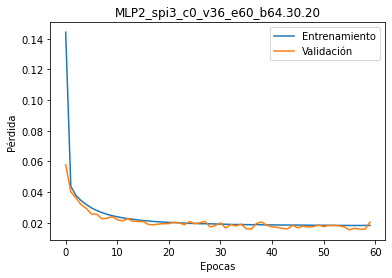

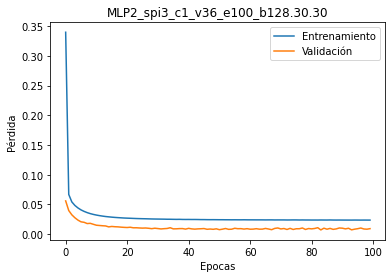

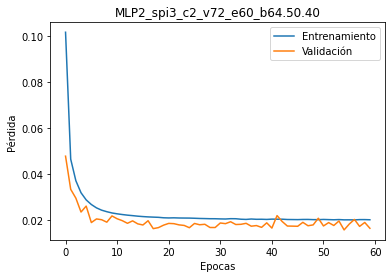

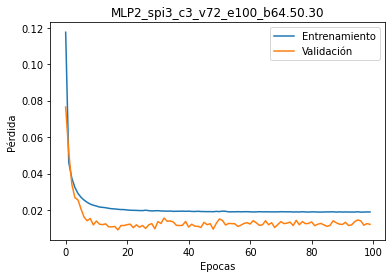

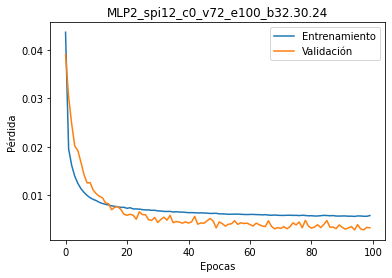

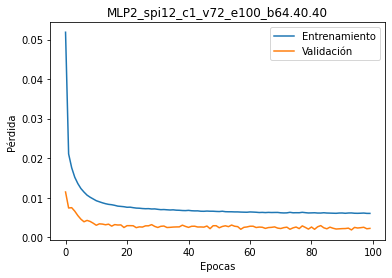

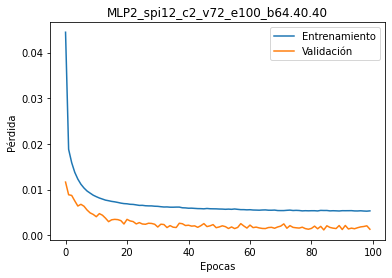

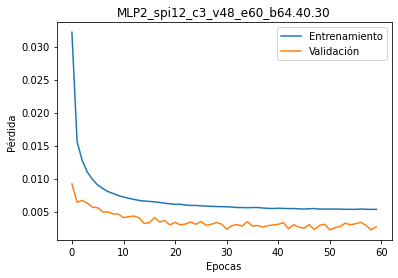

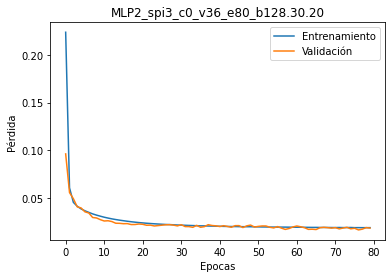

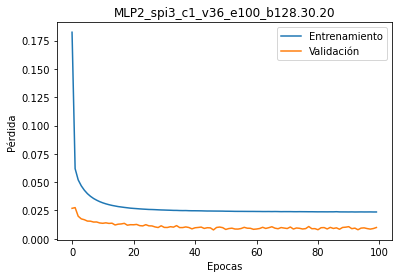

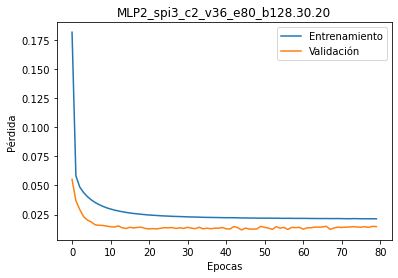

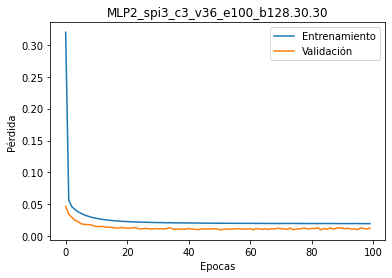

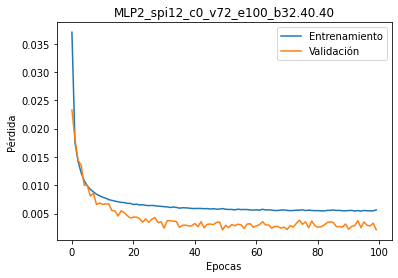

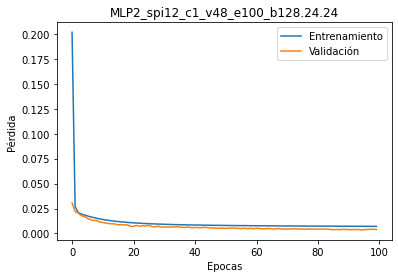

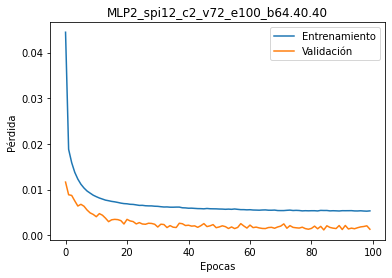

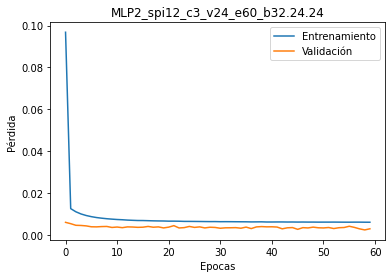

In [20]:
'''Cargar archivo con los clusters'''
cluster = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/cluster_4.csv',  sep = ',', usecols = {'id', 'cluster'})

'''Definir el horizonte de la prediccion'''
hpred = 12  #Horizonte de Predicción 

'''Definir DF de evaluacion y prediccion'''
mlp_eval = pd.DataFrame(index=['MAE','MAPE' ,'RMSE','MSE'])
mlp_pred = pd.DataFrame()

'''Definir todos los hiperparámetros'''
error='mse' #mae o mse

'''Para SPI 3'''
'''lind,lesc,cluster,lclu,ventana,epocas,x1,x2,tbatch,error):'''
modelo_mlp('spi',3,cluster,0,36,60,30,20,64,error)
modelo_mlp('spi',3,cluster,1,36,100,30,30,128,error)
modelo_mlp('spi',3,cluster,2,72,60,50,40,64,error)
modelo_mlp('spi',3,cluster,3,72,100,50,30,64,error)
'''Para SPI 12'''
modelo_mlp('spi',12,cluster,0,72,100,30,24,32,error)
modelo_mlp('spi',12,cluster,1,72,100,40,40,64,error)
modelo_mlp('spi',12,cluster,2,72,100,40,40,64,error)
modelo_mlp('spi',12,cluster,3,48,60,40,30,64,error)
'''Para SPEI 3'''
modelo_mlp('spi',3,cluster,0,36,80,30,20,128,error)
modelo_mlp('spi',3,cluster,1,36,100,30,20,128,error)
modelo_mlp('spi',3,cluster,2,36,80,30,20,128,error)
modelo_mlp('spi',3,cluster,3,36,100,30,30,128,error)
'''Para SPEI 12'''
modelo_mlp('spi',12,cluster,0,72,100,40,40,32,error)
modelo_mlp('spi',12,cluster,1,48,100,24,24,128,error)
modelo_mlp('spi',12,cluster,2,72,100,40,40,64,error)
modelo_mlp('spi',12,cluster,3,24,60,24,24,32,error)


# **Perceptrón Multicapa MLP (Multi-Layer Perceptron)**

In [ ]:
'''Cargar archivo con los clusters'''
cluster = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/cluster_4.csv',  sep = ',', usecols = {'id', 'cluster'})

'''Definir el horizonte de la prediccion'''
hpred = 12  #Horizonte de Predicción 

'''Definir los hiperparamentros de RN'''
lista_epocas = [100]  #[60,100,140]
lista_tbatch = [32,64] #[32,64,128]
error='mse' #mae o mse

'''lista de neuronas para las capas ocultas'''
lista_c1 = [24,30,40]
lista_c2 = [24,30,40]

'''Definir otras variables de los datos SPI-SPEI'''
lista_indice = ['spi','spei']
lista_escala = [12]
lista_cluster = [0,1,2,3]


'''Definir DF de evaluacion y prediccion'''
mlp_eval = pd.DataFrame(index=['MAE','MAPE' ,'RMSE','MSE'])
mlp_pred = pd.DataFrame()

lista_ventana = [48,72]  #Pasado histórico [12,24,36,48,72]


In [ ]:
'''Perceptrón con dos capas - Determinación de Hiperparámetros óptimos'''
for lind in lista_indice:
  for lesc in lista_escala:
    for lclu in lista_cluster:
      # Cargar datos
      datos = cargar_datos('indices_'+lind+str(lesc)+'.csv', cluster,lclu)
      datos_p = procesa_datos(datos)
      '''Diferenciar las series para spi y spei 12'''
      datos_p_d = datos_p.diff()
      datos_p=datos_p_d.dropna()

      '''División del DataSet en Entramiento y test'''
      train = datos_p.iloc[:-hpred]
      test = datos_p.iloc[-hpred:]

      '''Normalizar datos'''
      s_train = []
      for i in list(train):
          s_train.append(train[i].tolist())

      s_test = []
      for i in list(test):
          s_test.append(test[i].tolist())

      s_train = np.asarray(s_train)
      s_test = np.asarray(s_test)

      train_norm = []
      #Obtener los parámetros de normalización de train
      lista_param = []

      for s in s_train:
        params = {}
        params['max'] = s.max()
        params['min'] = s.min()
        lista_param.append(params)
        norm = normalizar_datos(s, params)
        train_norm.append(norm)
      # Aplicar los parámetros de normalización al test 
      test_norm = []
      for x, s in enumerate(s_test):
        params = lista_param[x]
        norm = normalizar_datos(s,params)
        test_norm.append(norm)
      test_norm[len(test_norm)-1]


      for ventana in lista_ventana:
        '''ventana movil'''
        x_train, y_train = [], []
        x_test, y_test = [], []

        for i, ts in enumerate(train_norm):
          # Train data
          ts_x_train, ts_y_train = [], []
          for j in range(0, ts.shape[0] - hpred + 1):
              indices = range(j - ventana, j, 1)
              
              ts_x_train.append(np.reshape(ts[indices], (ventana, 1)))
              ts_y_train.append(ts[j:j + hpred])
          x_train.extend(np.asarray(ts_x_train))
          y_train.extend(np.asarray(ts_y_train))
          # Test data
          ts_x_test = np.reshape(np.asarray(ts[-ventana:]), (ventana, 1))
          ts_y_test=  test_norm[i]
          x_test.extend(np.asarray([ts_x_test]))
          y_test.extend(np.asarray([ts_y_test]))
          
        x_train, y_train = np.asarray(x_train), np.asarray(y_train)
        x_test, y_test = np.asarray(x_test), np.asarray(y_test, dtype='float32')

        # Fijar la semilla para los experimentos
        tf.keras.backend.clear_session()
        np.random.seed(1)
        tf.random.set_seed(1)
        random.seed(1)

        for epocas in lista_epocas:
          for tbatch in lista_tbatch:
            # print(f'Ventana:{ventana}, epoca:{epocas}, tbatch:{tbatch}')

            for x1 in lista_c1:
              if x1<=ventana:
                for x2 in lista_c2:
                  if x2<=x1:
                    # print(f'x1:{x1}, x2:{x2}, x3:{x3}')
                    print('MLP2_'+lind+str(lesc)+'_c'+str(lclu)+'_v'+str(ventana)+'_e'+str(epocas)+'_b'+str(tbatch)+'.'+str(x1)+'.'+str(x2))

                    ''' PERCEPTRON MULTICAPA MLP'''
                    inp = Input(shape=x_train.shape[-2:])
                    x = Flatten()(inp)
                    x = Dense(x1)(x)
                    x = Dense(x2)(x)
                    x = Dense(hpred)(x)
                    model = keras.Model(inputs=inp, outputs=x)
                    model.compile(optimizer='adam', loss=error)
                    print(model.summary())

                    history = model.fit(x_train, y_train,
                              batch_size=tbatch,
                              epochs=epocas,
                              verbose=1,
                              validation_data=(x_test, y_test))
                    
                    nom_columna = 'MLP2'+lind+str(lesc)+'_c'+str(lclu)+'_v'+str(ventana)+'_e'+str(epocas)+'_b'+str(tbatch)+'.'+str(x1)+'.'+str(x2)
                    # Graficas de entrenamiento y validación
                    plt.figure()
                    plt.title('MLP2_'+lind+str(lesc)+'_c'+str(lclu)+'_v'+str(ventana)+'_e'+str(epocas)+'_b'+str(tbatch)+'.'+str(x1)+'.'+str(x2))
                    plt.xlabel('Epocas')
                    plt.ylabel('Pérdida')
                    plt.plot(history.history['loss'])
                    plt.plot(history.history['val_loss'])
                    plt.legend(['Entrenamiento', 'Validación'])
                    plt.savefig('/content/gdrive/My Drive/Resultados_MLP/SPI_SPEI12_dif/'+nom_columna+'.png', dpi=300 , transparent=False)
                    # plt.show()

                    predicciones = model.predict(x_test)
                    
                    # mlp_eval[nom_columna]=evaluar(y_test,predicciones)
                    with open('/content/gdrive/My Drive/Resultados_MLP/SPI_SPEI12_dif/eval_'+lind+str(lesc)+'_c'+str(lclu)+'_MPL2_.txt', 'a') as f:
                      f.write(nom_columna+','+str(evaluar(y_test,predicciones))+'\n')
                    # mlt = pd.DataFrame(predicciones, index=['mlt'+datos_p.columns.astype(str)]).T
                    # mlp_pred=pd.concat([mlp_pred,mlt],axis=1)
